In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Goal, purpose, target and initial hypothesis
#### Goal - Reduce churn
#### Purpose - Prevent revenue lost due to customers leaving (who are then typically harder/costlier to get back).  Could also indicate service delivery issues we aren't aware of.
#### Target - Churn
#### Constraints - Cannot remove month-to-month service plan
#### Initial hypotheses:

- Having to pay by check each month makes customers more prone to churn (extra work)
- Having multiple services makes customers less likely to churn
- Type of internet services may have an impact (one may be slower or costlier)
- Larger familes (i.e. dependants & partners) may impact churn - could adjust business plans to accomodate
- Number of phone lines may impact churn - more phone lines are probably lower churn.

In [60]:
df = pd.read_csv('storytelling_project_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer_id                7049 non-null   object 
 1   gender                     7049 non-null   object 
 2   is_senior_bool             7049 non-null   int64  
 3   is_senior                  7049 non-null   object 
 4   payment_type               7049 non-null   object 
 5   monthly_charges            7049 non-null   float64
 6   total_charges              7038 non-null   float64
 7   churn                      7049 non-null   object 
 8   tenure                     7049 non-null   float64
 9   is_female_bool             7049 non-null   int64  
 10  has_churned_bool           7049 non-null   int64  
 11  has_phone_bool             7049 non-null   int64  
 12  has_internet_bool          7049 non-null   int64  
 13  contract_details           7049 non-null   objec

In [61]:
df.head(5).T

,0,1,2,3,4
customer_id,0002-ORFBO,0003-MKNFE,0004-TLHLJ,0011-IGKFF,0013-EXCHZ
gender,Female,Male,Male,Male,Female
is_senior_bool,0,0,0,1,1
is_senior,Non-Senior Citizen,Non-Senior Citizen,Non-Senior Citizen,Senior Citizen,Senior Citizen
payment_type,Mailed check,Mailed check,Electronic check,Electronic check,Mailed check
monthly_charges,65.6,59.9,73.9,98.0,83.9
total_charges,593.3,542.4,280.85,1237.85,267.4
churn,No,No,Yes,Yes,Yes
tenure,9.0,9.1,3.8,12.6,3.2
is_female_bool,1,0,0,0,1


In [62]:
# what is the percent of overall churn
df[df.churn == "Yes"].shape[0] / df.shape[0]

0.2652858561498085

#### 26.5% of their customers have churned

In [63]:
lost = df[df.churn == "Yes"]
kept = df[df.churn == "No"]

In [64]:
# how quickly do folks churn, on average
churn_tenure = lost.tenure.mean()
churn_tenure

17.96108563533476

In [65]:
# how does the tenure of non-churning customers compare
non_churn_tenure = kept.tenure.mean()
non_churn_tenure

37.586025552198315

#### Customers churn, on average, in 17 months, while non-churners are around 37 months of service

In [66]:
# Cost of the loss of these customers
loss_per_churn = (non_churn_tenure - churn_tenure) * df.monthly_charges.mean()
loss_per_churn

1270.6562548523746

#### They are losing $1270 for each customer churning.

In [67]:
total_churn_loss = loss_per_churn * lost.shape[0]
total_churn_loss

2376127.1965739406

#### They lost almost $2.4M in revenue due to churn.

<AxesSubplot:xlabel='churn', ylabel='monthly_charges'>

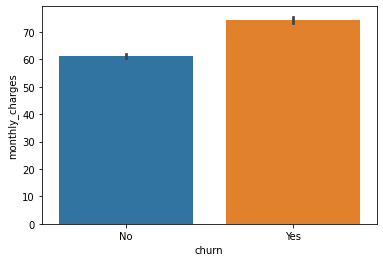

In [40]:
lost.monthly_charges.mean(), kept.monthly_charges.mean()
sns.barplot(x = 'churn', y = 'monthly_charges', data = df)

Churned customers are paying about 13 dollars more per month - lets see what that means in services

<AxesSubplot:title={'center':'Current Customers'}>

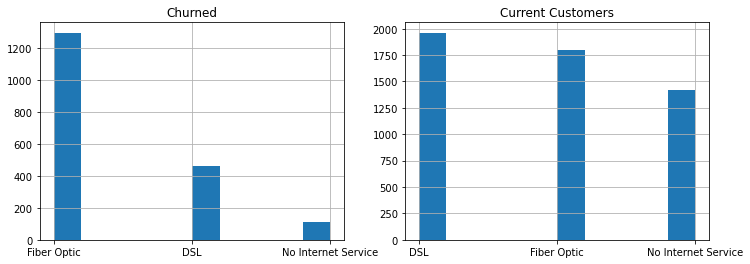

In [69]:
# After doing some pivot tables I noticed most churn is coming from combo customers (hence higher average cost) specifically those using fiber
plt.figure(figsize = (12,4))

plt.subplot(1,2,1, title = "Churned")
lost.internet_service_details.hist()

plt.subplot(1,2,2, title = "Current Customers")
kept.internet_service_details.hist()

In [70]:
df.groupby('churn').payment_type.value_counts()

churn  payment_type             
No     Mailed check                 1304
       Electronic check             1294
       Credit card (automatic)      1292
       Bank transfer (automatic)    1289
Yes    Electronic check             1071
       Mailed check                  308
       Bank transfer (automatic)     259
       Credit card (automatic)       232
Name: payment_type, dtype: int64

Electronic check seems to be an indicator of churn - almost half of those who use this method are churning, majority of churns are this method.

In [72]:
sample1 = df[['churn','internet_service_details','payment_type']]

,churn,internet_service_details,payment_type
0,No,DSL,Mailed check
1,No,DSL,Mailed check
2,Yes,Fiber Optic,Electronic check
3,Yes,Fiber Optic,Electronic check
4,Yes,Fiber Optic,Mailed check
...,...,...,...
7044,No,DSL,Mailed check
7045,Yes,Fiber Optic,Electronic check
7046,No,DSL,Mailed check
7047,No,DSL,Mailed check


In [ ]:
# Ryan, check to see what churn is when you remove electronic checks and if that is in line with normalcy
# Also, check what the main drivers are of 1 month and leave vs sticking around.  If someone stays more than one month how long do they typically stay?

In [90]:
short_churned = df[(df.full_months_tenure<=1) & (df.churn == "Yes")]

In [91]:
short_churned.service_combination.value_counts()

Phone & Internet    335
Phone Only           64
Internet Only        50
Name: service_combination, dtype: int64

In [93]:
short_stayed = df[(df.full_months_tenure<=1) & (df.churn == "No")]
short_stayed.service_combination.value_counts()

Phone & Internet    146
Phone Only          135
Internet Only        26
Name: service_combination, dtype: int64

In [87]:
335/(335+146), 64/(64+135), 50/(50+26)

(0.6964656964656964, 0.32160804020100503, 0.6578947368421053)

In [94]:
short_churned.internet_service_details.value_counts()

Fiber Optic            240
DSL                    145
No Internet Service     64
Name: internet_service_details, dtype: int64

In [95]:
short_stayed.internet_service_details.value_counts()

No Internet Service    135
DSL                    119
Fiber Optic             53
Name: internet_service_details, dtype: int64

In [98]:
240/(240+53), 145/(145+119), 64/(64+135)

(0.8191126279863481, 0.5492424242424242, 0.32160804020100503)

Most people who churn within one month are internet users, specifically those with fiber.

<AxesSubplot:xlabel='churn', ylabel='full_months_tenure'>

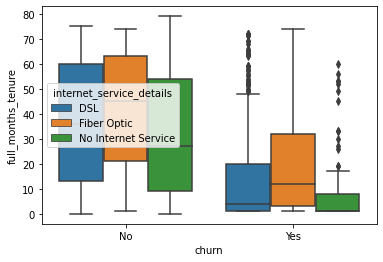

In [102]:
sns.boxplot(x = "churn", y = "full_months_tenure", hue = "internet_service_details", data = df)